In [2]:
''' Import libraries '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
from tqdm import tqdm
from utils import *
from gans import synthetic_data_generation
import warnings
warnings.filterwarnings("ignore")

In [3]:
INPUT_VARS = ['x_' + str(i) for i in range(1, 10 + 1)]
RESPONSE_VARS = ['y']

''' Read data & split to train / test '''
data_A = pd.read_csv('data/ART/data_A.csv', index_col=0)
data_B = pd.read_csv('data/ART/data_B.csv', index_col=0)
data_C = pd.read_csv('data/ART/data_C.csv', index_col=0)
data_AB = pd.concat([data_A, data_B], axis=0)

X_A = data_A[INPUT_VARS]
y_A = data_A[RESPONSE_VARS]
X_B = data_B[INPUT_VARS]
y_B = data_B[RESPONSE_VARS]
X_C = data_C[INPUT_VARS]
y_C = data_C[RESPONSE_VARS]

print(f'X_A shape: {X_A.shape} \nX_B shape: {X_B.shape} \nX_C shape: {X_C.shape}')

X_A shape: (100, 10) 
X_B shape: (16, 10) 
X_C shape: (16, 10)


In [4]:
# Split X_A and y_A to train and validation
X_train, X_val, y_train, y_val = train_test_split(X_A, y_A, test_size=0.2, random_state=42)

print(f'Train shape: {X_train.shape} \nValidation shape: {X_val.shape}')

Train shape: (80, 10) 
Validation shape: (20, 10)


In [4]:
''' Train ML models '''
def ml_training(X_train, y_train, param_grid, model):
    ''' Train ML model on train set '''
    grid = GridSearchCV(model, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train.values.ravel())
    model = grid.best_estimator_
    print(f'Best model: {model}')
    return model

params_svr = {'kernel': ['linear', 'rbf', 'sigmoid'], 'gamma': [0.001, 0.01, 0.05, 0.1, 1, 2, 5, 10], 
              'C': [100, 300, 400, 500], 'epsilon': [0.001, 0.1, 0.2, 0.5, 1.0]}

model = ml_training(X_train, y_train, params_svr, SVR())
# model = SVR(C=300, gamma=0.001).fit(X_train, y_train)  ## DELETE THIS LINE
y_pred = model.predict(X_val)
print(f'MAE: {mean_absolute_error(y_val, y_pred)}')
print(f'MSE: {mean_squared_error(y_val, y_pred)}')
print(f'R2: {r2_score(y_val, y_pred)}')
# Fit mode to all data_A
model.fit(X_A, y_A)

Best model: SVR(C=400, epsilon=0.001, gamma=0.001)
MAE: 0.7012892962496424
MSE: 0.9362648154126039
R2: 0.9904242298763898


SVR(C=400, epsilon=0.001, gamma=0.001)

### Conformal Predictive Distributions

In [ ]:
from crepes import WrapClassifier, WrapRegressor, __version__, ConformalPredictiveSystem
from crepes.extras import margin, DifficultyEstimator, binning
print(f"crepes v. {__version__}")

In [ ]:
X_train = X_train
y_train = y_train.values.ravel()

In [ ]:
X_prop_train, X_cal, y_prop_train, y_cal = train_test_split(X_train, y_train, test_size=0.30, random_state=42)

wrapper = WrapRegressor(model)
wrapper.fit(X_train, y_train)
wrapper.calibrate(X_cal, y_cal)

# The conformal regressor can now produce prediction intervals for the data with a sonfidence level
wrapper.predict_int(X_val, confidence=0.95)

In [ ]:
# Objects considered more difficult will be assigned wider intervals.
de = DifficultyEstimator()
de.fit(X_prop_train, y_prop_train, k=5, beta=0.01)
sigmas_cal = de.apply(X_cal)

wrapper.calibrate(X_cal, y_cal, sigmas=sigmas_cal)
sigmas_test = de.apply(X_test)
wrapper.predict_int(X_test, sigmas=sigmas_test, confidence=0.90, y_min=0)

In [ ]:
# Use of Mondorian categories; equal-sized binning of the difficulty estimates
bins_cal, bin_thresholds = binning(sigmas_cal, bins=2)
wrapper.calibrate(X_cal, y_cal, bins=bins_cal)

bins_test = binning(sigmas_test, bins=bin_thresholds)
wrapper.predict_int(X_test, bins=bins_test, confidence=.90, y_min=0)

### SHAP Values

100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


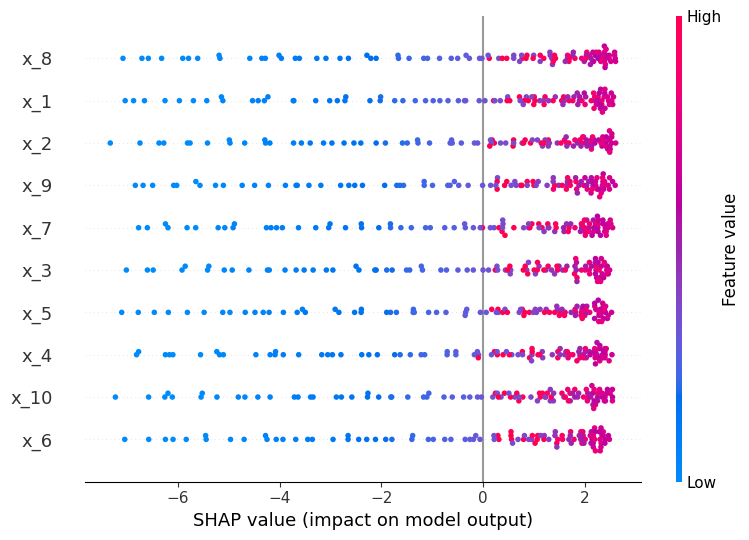

In [41]:
''' SHAP Values'''
import shap
shap.initjs()

def shap_plot(j):
    explainerModel = shap.KernelExplainer(model.predict, X_A)
    shap_values_Model = explainerModel.shap_values(X_A)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], X_A.iloc[[j]])
    return p

explainer = shap.KernelExplainer(model.predict, X_A)
shap_values = explainer.shap_values(X_A)

# Summary plot
shap.summary_plot(shap_values, X_A)

### Counterfactual Explanation

In [5]:
best_idx = data_A.sort_values(by='y', ascending=False).head(3).index.values
print(f'Top {len(best_idx)} best samples indexes: {best_idx}')
data_A.sort_values(by='y', ascending=False).head(3)

Top 3 best samples indexes: [10 95  8]


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y,Cluster
10,0.039282,9.166387,0.095211,2.451616,4.937954,4.022387,5.701144,3.388970,4.684635,3.929491,17.218924,0
95,1.085196,7.917272,9.107254,6.924994,8.872192,0.854867,3.685636,7.087835,5.941889,4.410693,16.609165,0
8,9.344719,4.944110,1.767454,4.873491,8.121612,8.409447,1.236645,8.330787,2.474939,1.007552,15.171359,0


In [5]:
import dice_ml
from dice_ml import Dice

d = dice_ml.Data(dataframe=data_A.drop('Cluster', axis=1), continuous_features=INPUT_VARS, outcome_name='y')
m = dice_ml.Model(model=model, backend="sklearn", model_type='regressor')
exp_genetic = Dice(d, m, method="genetic")

_ = data_A.drop(['Cluster', 'y'], axis=1)
query_instances = _[10:11]
genetic_housing = exp_genetic.generate_counterfactuals(query_instances, total_CFs=5, desired_range=[20, 25])
genetic_housing.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:22<00:00, 22.66s/it]

Query instance (original outcome : 17.220149993896484)


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,0.039282,9.166387,0.095211,2.451616,4.937954,4.022388,5.701144,3.38897,4.684635,3.929491,17.22015



Diverse Counterfactual set (new outcome: [20, 25])


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
0,8.560610359,-,1.058225912,3.486637,6.675237953,5.76106572,4.812836656,4.977907011,4.75609977,5.020790792,20.298257844063784
0,1.542906684,6.59029685,1.398041186,7.08533711,1.454353597,4.61642174,3.843077955,2.173775677,5.34854003,4.280000625,20.111920330496133
0,3.799053463,4.6362345,2.063101744,1.28070292,4.24300635,4.580029501,6.116355267,7.28782556,5.53174145,5.52274662,22.71777816673611
0,7.599937564,7.28051675,0.570441519,6.8196049,6.842066275,4.42214175,6.12069807,4.213851224,2.34628947,2.897618575,20.31272168904151
0,2.39345446,2.24531717,2.354963082,2.81812315,3.530872575,2.554248237,4.102222066,4.741025967,6.32826774,1.173599604,20.78101516456816


In [28]:
dd = [[1.769333695, 5.62707073, 5.44514002, 4.2295382, 6.740340023, 2.666173475, 5.247103783, 3.048207193, 5.35352691, 3.899936623, 23.46338386801314],
[4.488004124, 5.6371164, 2.672448894, 3.20856055, 1.062801018, 3.845587913, 4.6509309, 4.086221992, 3.74030719, 4.908540717, 23.270224629682644],
[1.769333695, 5.62707073, 5.44514002, 4.2295382, 6.740340023, 2.666173475, 5.30210289, 3.048207193, 5.35352691, 6.395643803, 23.272441296294772],
[2.977024814, 4.86392005, 4.872602202, 5.17343729, 4.036707255, 4.363394006, 5.247103783, 0.879696188, 4.14312636, 3.899936623, 23.566600158860908],
[-0.062437494, 3.41778114, 2.631463894, 4.88504354, 3.807540614, 5.423667469, 5.342439922, 6.070282865, 3.97587057, 8.679521679, 20.213609423595045]]

In [36]:
''' Get the mean value of i-th feature '''
sum = 0
for i in range(5):
    sum += (dd[i][0])
print(sum/5)

2.1882517668


### PDP plot

In [53]:
data_C.describe()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,5.039083,5.191129,5.125282,4.677884,5.091928,4.865806,4.866883,5.460318,5.532003,4.770489,23.961452
std,1.300325,0.751114,0.923419,0.965946,1.002856,0.825003,0.934727,0.981345,1.074244,1.249291,0.148593
min,2.892308,4.090545,3.504112,3.411547,3.790316,3.577096,3.336893,3.453670,3.794478,2.771586,23.808507
25%,4.144772,4.626686,4.544650,3.896079,4.310035,4.280909,4.150237,4.895357,4.862776,3.953552,23.836716
50%,5.027176,5.132717,5.410308,4.548133,4.888893,4.839860,4.828065,5.281942,5.538714,4.285760,23.911207
75%,6.076005,5.537906,5.689350,5.081531,5.736343,5.338639,5.555899,6.334625,6.355002,5.545394,24.072366
max,7.049882,6.520730,6.358142,6.552833,7.245222,6.305235,6.320137,6.774185,7.404642,7.188898,24.250769


In [40]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

from interpret import show
from interpret.blackbox import PartialDependence

pdp = PartialDependence(model, X_A)
show(pdp.explain_global(), 0)

In [ ]:
# Create input vector for ML model
new_data = np.zeros((1,9))

new_data[0][0] = 0.2       # ATOB_ECOLI
new_data[0][1] = 0.3       # ERG8_YEAST
new_data[0][2] = 2.4    # IDI_ECOLI
new_data[0][3] = 1.3       # KIME_YEAST
new_data[0][4] = 2.21       # MVD1_YEAST
new_data[0][5] = 14     # Q40322_MENSP
new_data[0][6] = 4.5    # Q8LKJ3_ABIGR
new_data[0][7] = 0.4       # Q9FD86_STAAU
new_data[0][8] = 0.5      # Q9FD87_STAAU

model.predict(new_data)

### LIME

In [ ]:
from interpret.blackbox import LimeTabular

lime = LimeTabular(model, X_train)

show(lime.explain_local(X_train[:5], y_train[:5]), 0)

### SHAP Values